In [ ]:
from google.colab import drive
drive.mount('/content/drive')


ValueError: mount failed

In [ ]:
# Base dataset directory
BASE_PATH = "/content/drive/MyDrive/thermal ds"

# Curriculum datasets
PATH_SEPARATE = f"{BASE_PATH}/Augmented_Separate_Physics_Dataset"
PATH_STOCHASTIC = f"{BASE_PATH}/Augmented_Combined_Stochastic"
PATH_CLEAN = f"{BASE_PATH}/IR-Motor-bmp"

print("Separate:", PATH_SEPARATE)
print("Stochastic:", PATH_STOCHASTIC)
print("Clean:", PATH_CLEAN)


Separate: /content/drive/MyDrive/thermal ds/Augmented_Separate_Physics_Dataset
Stochastic: /content/drive/MyDrive/thermal ds/Augmented_Combined_Stochastic
Clean: /content/drive/MyDrive/thermal ds/IR-Motor-bmp


In [ ]:
import os

def show_folders(path):
    print(f"\nFolders in {path}:")
    for f in sorted(os.listdir(path)):
        print(" -", f)

show_folders(PATH_SEPARATE)
show_folders(PATH_STOCHASTIC)
show_folders(PATH_CLEAN)



Folders in /content/drive/MyDrive/thermal ds/Augmented_Separate_Physics_Dataset:
 - A&B50
 - A&C&B10
 - A&C&B30
 - A&C10
 - A&C30
 - A10
 - A30
 - A50
 - Fan
 - Noload
 - Rotor-0

Folders in /content/drive/MyDrive/thermal ds/Augmented_Combined_Stochastic:
 - A&B50
 - A&C&B10
 - A&C&B30
 - A&C10
 - A&C30
 - A10
 - A30
 - A50
 - Fan
 - Noload
 - Rotor-0

Folders in /content/drive/MyDrive/thermal ds/IR-Motor-bmp:
 - A&B50
 - A&C&B10
 - A&C&B30
 - A&C10
 - A&C30
 - A10
 - A30
 - A50
 - Fan
 - Noload
 - Read me.txt
 - Rotor-0


In [ ]:
# Class to index mapping
CLASS_MAP = {
    "A10": 0,
    "A30": 1,
    "A50": 2,
    "A&C10": 3,
    "A&C30": 4,
    "A&B50": 5,
    "A&C&B10": 6,
    "A&C&B30": 7,
    "Fan": 8,
    "Rotor-0": 9,
    "Noload": 10
}

# Severity mapping (normalized 0–1)
SEVERITY_MAP = {
    "A10": 0.1,
    "A30": 0.3,
    "A50": 0.5,
    "A&C10": 0.1,
    "A&C30": 0.3,
    "A&B50": 0.5,
    "A&C&B10": 0.1,
    "A&C&B30": 0.3,
    "Fan": 1.0,
    "Rotor-0": 1.0,
    "Noload": 0.0
}

NUM_CLASSES = len(CLASS_MAP)
print("Total classes:", NUM_CLASSES)


Total classes: 11


In [ ]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

def extract_physics_features(img_gray, mask, motor_mask):
    eps = 1e-6

    area_ratio = mask.sum() / (motor_mask.sum() + eps)

    T_hot = img_gray[mask == 1].mean()
    T_motor = img_gray[motor_mask == 1].mean()
    delta_T = T_hot - T_motor
    std_T = img_gray[mask == 1].std()

    contours, _ = cv2.findContours(
        mask.astype(np.uint8),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    if contours:
        cnt = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        compactness = (perimeter ** 2) / (4 * np.pi * area + eps)
    else:
        compactness = 0.0

    return np.array([area_ratio, delta_T, std_T, compactness], dtype=np.float32)

class ThermalDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def generate_hotspot_mask(self, img_gray):
        # Normalize
        img = img_gray.astype(np.float32)
        img = img - np.min(img)
        img = img / (np.max(img) + 1e-6)

        # Motor region (strong constraint)
        motor_mask = img > np.percentile(img, 40)
        img_motor = img * motor_mask

        # Local contrast threshold
        mean = np.mean(img_motor[img_motor > 0])
        std = np.std(img_motor[img_motor > 0])

        hotspot = img_motor > (mean + 0.8 * std)

        # Relax if needed
        if np.sum(hotspot) < 100:
            hotspot = img_motor > (mean + 0.5 * std)

        # Morphological cleanup (NO gradient)
        hotspot = hotspot.astype(np.uint8)
        kernel = np.ones((5, 5), np.uint8)
        hotspot = cv2.morphologyEx(hotspot, cv2.MORPH_OPEN, kernel)
        hotspot = cv2.morphologyEx(hotspot, cv2.MORPH_CLOSE, kernel)

        # Enforce motor boundary (critical)
        hotspot = hotspot & motor_mask.astype(np.uint8)

        # Final safety fallback
        if np.sum(hotspot) < 50:
            hotspot = motor_mask.astype(np.uint8)

        return hotspot



    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Generate hotspot mask (at original image size)
        mask_original_size = self.generate_hotspot_mask(img_gray)

        # Generate motor mask (at original image size) for physics features computation
        img_normalized_for_motor_mask = img_gray.astype(np.float32)
        img_normalized_for_motor_mask = img_normalized_for_motor_mask - np.min(img_normalized_for_motor_mask)
        img_normalized_for_motor_mask = img_normalized_for_motor_mask / (np.max(img_normalized_for_motor_mask) + 1e-6)
        motor_mask_original_size = img_normalized_for_motor_mask > np.percentile(img_normalized_for_motor_mask, 40)
        motor_mask_original_size = motor_mask_original_size.astype(np.uint8)

        # Extract physics features
        phys_feats = extract_physics_features(img_gray, mask_original_size, motor_mask_original_size)

        # Resize mask to CNN input size
        mask_for_cnn = cv2.resize(mask_original_size, (224, 224))

        # To tensor
        img = img / 255.0
        img = torch.tensor(img).permute(2, 0, 1).float()
        mask_for_cnn = torch.tensor(mask_for_cnn).unsqueeze(0).float()
        phys_feats = torch.tensor(phys_feats).float()

        if self.transform:
            img = self.transform(img)

        return img, mask_for_cnn, label, phys_feats

    def __len__(self):
        return len(self.image_paths)

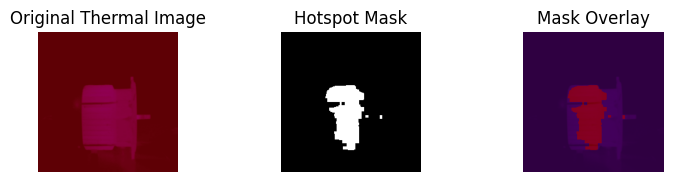

Class label: 1


In [ ]:
import matplotlib.pyplot as plt
import os # Added for path operations
from torchvision import transforms

# Define IMG_SIZE (from cell 5f83e5e6)
IMG_SIZE = 224

# Define image_transform (from cell 61ab7422)
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Pick one sample index
idx = 0

# --- FIX: Instantiate the dataset ---
# Assuming PATH_CLEAN, CLASS_MAP, and image_transform are defined in previous cells
# Use a sample from PATH_CLEAN to create a small dataset for visualization
sample_class_name = "A30" # Example class
sample_folder_path = os.path.join(PATH_CLEAN, sample_class_name)

# Get the first .bmp image from the sample folder
image_files = [f for f in os.listdir(sample_folder_path) if f.lower().endswith(".bmp")]
if not image_files:
    raise FileNotFoundError(f"No .bmp images found in {sample_folder_path}")
sample_image_path = os.path.join(sample_folder_path, image_files[0])

# Create a list of image paths and corresponding labels
test_image_paths = [sample_image_path]
test_labels = [CLASS_MAP[sample_class_name]]

# Instantiate ThermalDataset (defined in cell 2HXDS8JgB5H7)
dataset = ThermalDataset(test_image_paths, test_labels, transform=image_transform)
# --- End of FIX ---

# Get one sample
img, mask, label, phys_feats = dataset[idx]   # make sure 'dataset' is instantiated and unpacking all 4 values

# Convert tensors to numpy
img_np = img.permute(1, 2, 0).numpy()
mask_np = mask.squeeze().numpy()

# Plot
plt.figure(figsize=(12,4))

plt.subplot(2,4,1)
plt.imshow(img_np)
plt.title("Original Thermal Image")
plt.axis("off")

plt.subplot(2,4,2)
plt.imshow(mask_np, cmap='gray')
plt.title("Hotspot Mask")
plt.axis("off")

plt.subplot(2,4,3)
plt.imshow(img_np)
plt.imshow(mask_np, cmap='jet', alpha=0.5)
plt.title("Mask Overlay")
plt.axis("off")

plt.show()

print("Class label:", label)

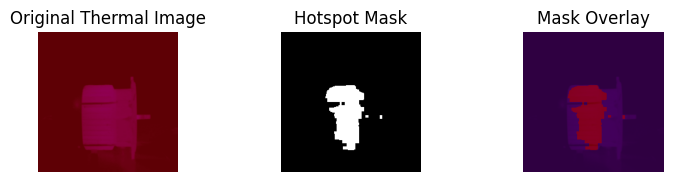

Class label: 1


In [ ]:
import matplotlib.pyplot as plt
import os # Added for path operations

# Pick one sample index
idx = 0

# --- FIX: Instantiate the dataset ---
# Assuming PATH_CLEAN, CLASS_MAP, and image_transform are defined in previous cells
# Use a sample from PATH_CLEAN to create a small dataset for visualization
sample_class_name = "A30" # Example class
sample_folder_path = os.path.join(PATH_CLEAN, sample_class_name)

# Get the first .bmp image from the sample folder
image_files = [f for f in os.listdir(sample_folder_path) if f.lower().endswith(".bmp")]
if not image_files:
    raise FileNotFoundError(f"No .bmp images found in {sample_folder_path}")
sample_image_path = os.path.join(sample_folder_path, image_files[0])

# Create a list of image paths and corresponding labels
test_image_paths = [sample_image_path]
test_labels = [CLASS_MAP[sample_class_name]]

# Instantiate ThermalDataset (defined in cell 2HXDS8JgB5H7)
dataset = ThermalDataset(test_image_paths, test_labels, transform=image_transform)
# --- End of FIX ---

# Get one sample
img, mask, label, phys_feats = dataset[idx]   # make sure 'dataset' is instantiated and unpacking all 4 values

# Convert tensors to numpy
img_np = img.permute(1, 2, 0).numpy()
mask_np = mask.squeeze().numpy()

# Plot
plt.figure(figsize=(12,4))

plt.subplot(2,4,1)
plt.imshow(img_np)
plt.title("Original Thermal Image")
plt.axis("off")

plt.subplot(2,4,2)
plt.imshow(mask_np, cmap='gray')
plt.title("Hotspot Mask")
plt.axis("off")

plt.subplot(2,4,3)
plt.imshow(img_np)
plt.imshow(mask_np, cmap='jet', alpha=0.5)
plt.title("Mask Overlay")
plt.axis("off")

plt.show()

print("Class label:", label)

In [ ]:
from torchvision import transforms

# Define image_transform
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [ ]:
# Check if hotspot leaks outside motor

# Re-generate motor_mask for validation as it's not returned by __getitem__
# The sample_image_path is available from the previous cell's execution.
original_img = cv2.imread(sample_image_path)
original_img_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

# Apply the same normalization as in generate_hotspot_mask
img_normalized = original_img_gray.astype(np.float32)
img_normalized = img_normalized - np.min(img_normalized)
img_normalized = img_normalized / (np.max(img_normalized) + 1e-6)

# Generate motor_mask based on the normalized image
motor_mask_original_size = img_normalized > np.percentile(img_normalized, 40)

# Resize motor_mask to match the size of 'mask_np' (224x224)
motor_mask_resized = cv2.resize(motor_mask_original_size.astype(np.uint8), (224, 224)).astype(bool)

# Use mask_np which is the 'mask' output from dataset[idx] converted to numpy
# Convert mask_np to boolean explicitly to allow bitwise operation
leak_pixels = np.sum(mask_np.astype(bool) & (~motor_mask_resized))

print("Leak pixels outside motor:", leak_pixels)
assert leak_pixels == 0, "❌ Hotspot outside motor!"

Leak pixels outside motor: 0


In [ ]:
area_ratio = mask.sum() / (motor_mask_resized.sum() + 1e-6)
print("Hotspot area ratio:", area_ratio)

Hotspot area ratio: tensor(0.3014)


In [ ]:
# Resize original_img_gray to match the mask size (224x224)
original_img_gray_resized = cv2.resize(original_img_gray, (224, 224))

T_hot = original_img_gray_resized[mask_np == 1].mean()
T_motor = original_img_gray_resized[motor_mask_resized == 1].mean()

print("Mean hotspot temp:", T_hot)
print("Mean motor temp:", T_motor)
print("ΔT:", T_hot - T_motor)

assert T_hot > T_motor, "❌ Hotspot not hotter than motor!"

Mean hotspot temp: 36.31427198462278
Mean motor temp: 27.299029548088065
ΔT: 9.015242436534713


In [ ]:
def compute_area_ratios(dataset, num_samples=50):
    ratios = []
    for i in range(num_samples):
        # Fix: Unpack all 4 values returned by dataset[i]
        img, mask_for_cnn, _, _ = dataset[i]
        img_gray = img.mean(dim=0).numpy()
        mask_np = mask_for_cnn.squeeze().numpy()

        motor_mask = img_gray > np.percentile(img_gray, 40)
        ratios.append(mask_np.sum() / (motor_mask.sum() + 1e-6))
    return ratios

In [ ]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader

# Re-define image_transform (IMG_SIZE is available from previous cells)
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Helper function to get image paths and labels for a dataset
def get_image_paths_and_labels(root_dir, class_map):
    all_image_paths = []
    all_labels = []
    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        # Ensure it's a directory and a valid class in our map
        if os.path.isdir(class_path) and class_name in class_map:
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.bmp', '.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    all_image_paths.append(img_path)
                    all_labels.append(class_map[class_name])
    return all_image_paths, all_labels

# Instantiate separate_dataset
sep_image_paths, sep_labels = get_image_paths_and_labels(PATH_SEPARATE, CLASS_MAP)
separate_dataset = ThermalDataset(sep_image_paths, sep_labels, transform=image_transform)

# Instantiate stochastic_dataset
sto_image_paths, sto_labels = get_image_paths_and_labels(PATH_STOCHASTIC, CLASS_MAP)
stochastic_dataset = ThermalDataset(sto_image_paths, sto_labels, transform=image_transform)

# Instantiate clean_dataset
clean_image_paths, clean_labels = get_image_paths_and_labels(PATH_CLEAN, CLASS_MAP)
clean_dataset = ThermalDataset(clean_image_paths, clean_labels, transform=image_transform)


sep_ratios = compute_area_ratios(separate_dataset)
sto_ratios = compute_area_ratios(stochastic_dataset)
clean_ratios = compute_area_ratios(clean_dataset)

# Define batch size
BATCH_SIZE = 32

# Create DataLoaders
separate_loader = DataLoader(separate_dataset, batch_size=BATCH_SIZE, shuffle=True)
stochastic_loader = DataLoader(stochastic_dataset, batch_size=BATCH_SIZE, shuffle=True)
clean_loader = DataLoader(clean_dataset, batch_size=BATCH_SIZE, shuffle=True)

/tmp/ipython-input-3653224025.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sep_ratios, sto_ratios, clean_ratios],


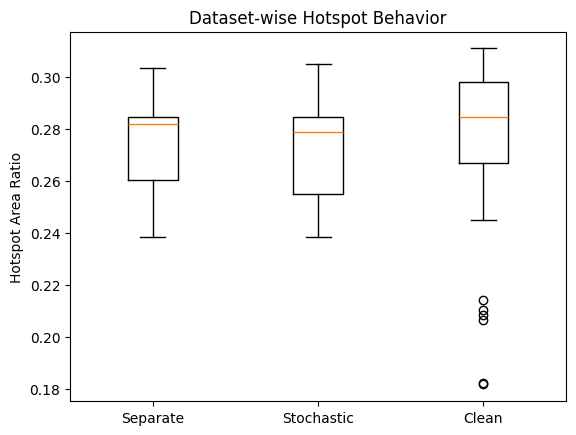

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([sep_ratios, sto_ratios, clean_ratios],
            labels=["Separate", "Stochastic", "Clean"])
plt.ylabel("Hotspot Area Ratio")
plt.title("Dataset-wise Hotspot Behavior")
plt.show()

In [ ]:
def extract_physics_features(img_gray, mask, motor_mask):
    eps = 1e-6

    area_ratio = mask.sum() / (motor_mask.sum() + eps)

    T_hot = img_gray[mask == 1].mean()
    T_motor = img_gray[motor_mask == 1].mean()
    delta_T = T_hot - T_motor
    std_T = img_gray[mask == 1].std()

    contours, _ = cv2.findContours(
        mask.astype(np.uint8),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    if contours:
        cnt = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        compactness = (perimeter ** 2) / (4 * np.pi * area + eps)
    else:
        compactness = 0.0

    return np.array([area_ratio, delta_T, std_T, compactness], dtype=np.float32)



In [ ]:
def __getitem__(self, idx):
    img = cv2.imread(self.image_paths[idx])
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    label = self.labels[idx]

    mask = self.generate_hotspot_mask(img_gray)
    motor_mask = img_gray > np.percentile(img_gray, 40)

    phys_feat = extract_physics_features(img_gray, mask, motor_mask)

    img = img / 255.0
    img = torch.tensor(img).permute(2, 0, 1).float()
    mask = torch.tensor(mask).unsqueeze(0).float()
    phys_feat = torch.tensor(phys_feat).float()

    return img, mask, label, phys_feat


In [ ]:
import torch.nn as nn
class PhysicsReliabilityNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
def physics_guided_fusion(features, mask, alpha):
    alpha = alpha.view(-1, 1, 1, 1)
    return alpha * (features * mask) + (1 - alpha) * features


In [ ]:
class PhysicsGuidedCNN(nn.Module):
    def __init__(self, num_classes=11):
        super().__init__()

        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])

        self.phys_net = PhysicsReliabilityNet()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x, mask, phys_feat):
        feats = self.backbone(x)

        mask = F.interpolate(mask, size=feats.shape[-2:], mode="nearest")
        alpha = self.phys_net(phys_feat)

        fused_feats = physics_guided_fusion(feats, mask, alpha)

        pooled = self.pool(fused_feats).view(x.size(0), -1)
        out = self.fc(pooled)

        return out, alpha


In [ ]:
from torchvision import models
import torch.nn.functional as F

class PhysicsGuidedCNN(nn.Module):
    def __init__(self, num_classes=11):
        super().__init__()

        # Backbone
        backbone = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])

        # Physics reliability
        self.phys_net = PhysicsReliabilityNet()

        # Classifier
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x, mask, phys_feat):
        feats = self.backbone(x)  # [B,512,7,7]

        # Resize mask
        mask = F.interpolate(mask, size=feats.shape[-2:], mode='nearest')

        # α computation
        alpha = self.phys_net(phys_feat)

        # Fusion
        fused_feats = physics_guided_fusion(feats, mask, alpha)

        # Classification
        pooled = self.pool(fused_feats).view(x.size(0), -1)
        out = self.fc(pooled)

        return out, alpha

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for imgs, masks, labels, phys_feats in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        phys_feats = phys_feats.to(device)

        optimizer.zero_grad()
        outputs, alpha = model(imgs, masks, phys_feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)



In [ ]:
from torchvision import models
import torch.nn.functional as F

In [ ]:
#extra
device = "cuda" if torch.cuda.is_available() else "cpu"

model = PhysicsGuidedCNN(num_classes=11).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# -------------------------
# Stage 1: Separate physics augmentations
# -------------------------
for epoch in range(5):
    loss = train_one_epoch(model, separate_loader, optimizer, criterion, device)
    print(f"Stage 1 | Epoch {epoch+1}/5 | Loss: {loss:.4f}")

for g in optimizer.param_groups:
    g["lr"] *= 0.5

# -------------------------
# Stage 2: Stochastic augmentations
# -------------------------
for epoch in range(5):
    loss = train_one_epoch(model, stochastic_loader, optimizer, criterion, device)
    print(f"Stage 2 | Epoch {epoch+1}/5 | Loss: {loss:.4f}")

# ✅ SAVE MODEL AFTER CURRICULUM
torch.save(model.state_dict(), "model_after_curriculum.pth")


Stage 1 | Epoch 1/5 | Loss: 0.5564
Stage 1 | Epoch 2/5 | Loss: 0.0780
Stage 1 | Epoch 3/5 | Loss: 0.0667
Stage 1 | Epoch 4/5 | Loss: 0.0196
Stage 1 | Epoch 5/5 | Loss: 0.0100


In [ ]:
from sklearn.model_selection import train_test_split

clean_train_paths, clean_test_paths, clean_train_labels, clean_test_labels = train_test_split(
    clean_image_paths,
    clean_labels,
    test_size=0.2,
    stratify=clean_labels,
    random_state=42
)

clean_train_dataset = ThermalDataset(clean_train_paths, clean_train_labels, transform=image_transform)
clean_test_dataset  = ThermalDataset(clean_test_paths, clean_test_labels, transform=image_transform)

clean_train_loader = DataLoader(
    clean_train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

clean_test_loader = DataLoader(
    clean_test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [ ]:
model.load_state_dict(torch.load("model_after_curriculum.pth"))
model.train()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=2e-5   # lower LR for fine-tuning
)

print("Final clean training started")

for epoch in range(5):
    loss = train_one_epoch(
        model,
        clean_train_loader,
        optimizer,
        criterion,
        device
    )
    print(f"Clean Train | Epoch {epoch+1}/10 | Loss: {loss:.4f}")

torch.save(model.state_dict(), "final_model_clean_retrained.pth")
print("Final retrained model saved")


NameError: name 'model' is not defined

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, masks, labels, phys_feats in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)
            phys_feats = phys_feats.to(device)

            outputs, alpha = model(imgs, masks, phys_feats)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = correct / total

    return avg_loss, accuracy, all_preds, all_labels


In [ ]:
model.eval()

test_loss, test_acc, preds, labels = evaluate(
    model,
    clean_test_loader,
    criterion,
    device
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

from sklearn.metrics import classification_report
print(classification_report(labels, preds))


NameError: name 'model' is not defined

In [ ]:
set(clean_train_paths).intersection(set(clean_test_paths))


set()

In [ ]:
np.random.shuffle(clean_test_labels)
print(classification_report(clean_test_labels, preds))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.14      0.14      0.14         7
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         6
           4       0.25      0.25      0.25         8
           5       0.12      0.12      0.12         8
           6       0.00      0.00      0.00         6
           7       0.12      0.12      0.12         8
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         5

    accuracy                           0.07        74
   macro avg       0.06      0.06      0.06        74
weighted avg       0.07      0.07      0.07        74



In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model = PhysicsGuidedCNN(num_classes=11).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# criterion = nn.CrossEntropyLoss()

# # Stage 1
# for epoch in range(20):
#     loss = train_one_epoch(model, separate_loader, optimizer, criterion, device)
#     print(f"Stage 1 | Epoch {epoch+1}/20 | Loss: {loss:.4f}")

# for g in optimizer.param_groups:
#     g["lr"] *= 0.5

# # Stage 2
# for epoch in range(20):
#     loss = train_one_epoch(model, stochastic_loader, optimizer, criterion, device)
#     print(f"Stage 2 | Epoch {epoch+1}/20 | Loss: {loss:.4f}")

# for g in optimizer.param_groups:
#     g["lr"] *= 0.2

# # Stage 3
# for epoch in range(10):
#     loss = train_one_epoch(model, clean_loader, optimizer, criterion, device)
#     print(f"Stage 3 | Epoch {epoch+1}/10 | Loss: {loss:.4f}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Stage 1 | Epoch 1/20 | Loss: 0.3407
Stage 1 | Epoch 2/20 | Loss: 0.0293
Stage 1 | Epoch 3/20 | Loss: 0.0093
Stage 1 | Epoch 4/20 | Loss: 0.0027
Stage 1 | Epoch 5/20 | Loss: 0.0019
Stage 1 | Epoch 6/20 | Loss: 0.0013
Stage 1 | Epoch 7/20 | Loss: 0.0011
Stage 1 | Epoch 8/20 | Loss: 0.0009
Stage 1 | Epoch 9/20 | Loss: 0.0006
Stage 1 | Epoch 10/20 | Loss: 0.0005
Stage 1 | Epoch 11/20 | Loss: 0.0004
Stage 1 | Epoch 12/20 | Loss: 0.0004
Stage 1 | Epoch 13/20 | Loss: 0.0003
Stage 1 | Epoch 14/20 | Loss: 0.0003
Stage 1 | Epoch 15/20 | Loss: 0.0003
Stage 1 | Epoch 16/20 | Loss: 0.0002
Stage 1 | Epoch 17/20 | Loss: 0.0650
Stage 1 | Epoch 18/20 | Loss: 0.0278
Stage 1 | Epoch 19/20 | Loss: 0.0044
Stage 1 | Epoch 20/20 | Loss: 0.0056
Stage 2 | Epoch 1/20 | Loss: 0.0026
Stage 2 | Epoch 2/20 | Loss: 0.0011
Stage 2 | Epoch 3/20 | Loss: 0.0007
Stage 2 | Epoch 4/20 | Loss: 0.0004
Stage 2 | Epoch 5/20 | Loss: 0.0003
Stage 2 | Epoch 6/20 | Loss: 0.0003
Stage 2 | Epoch 7/20 | Loss: 0.0003
Stage 2 | Epoch 8

In [ ]:
# torch.save(model.state_dict(), "final_physics_guided_model.pth")
# print("Final trained model saved")


Final trained model saved


In [ ]:
# model = PhysicsGuidedCNN(num_classes=11).to(device)
# model.load_state_dict(torch.load("final_physics_guided_model.pth"))
# model.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PhysicsGuidedCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
# torch.save(model.state_dict(), "model_stage2_stochastic.pth")
# print("Stage-2 model saved")


Stage-2 model saved


In [ ]:
# from sklearn.model_selection import train_test_split

# clean_train_paths, clean_test_paths, clean_train_labels, clean_test_labels = train_test_split(
#     clean_image_paths,
#     clean_labels,
#     test_size=0.2,
#     stratify=clean_labels,
#     random_state=42
# )


In [ ]:
# clean_train_dataset = ThermalDataset(clean_train_paths, clean_train_labels)
# clean_test_dataset  = ThermalDataset(clean_test_paths, clean_test_labels)

# clean_train_loader = DataLoader(
#     clean_train_dataset,
#     batch_size=16,
#     shuffle=True,
#     num_workers=2,
#     pin_memory=True
# )

# clean_test_loader = DataLoader(
#     clean_test_dataset,
#     batch_size=16,
#     shuffle=False,
#     num_workers=2,
#     pin_memory=True
# )


In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model = PhysicsGuidedCNN(num_classes=11).to(device)
# model.load_state_dict(torch.load("model_stage2_stochastic.pth"))
# model.train()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PhysicsGuidedCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=2e-5   # LOWER LR for fine-tuning
# )

# criterion = nn.CrossEntropyLoss()


In [ ]:
# print("Stage 3 (Clean IR Retraining Started)")

# for epoch in range(10):
#     loss = train_one_epoch(
#         model,
#         clean_train_loader,
#         optimizer,
#         criterion,
#         device
#     )
#     print(f"Stage 3 | Epoch {epoch+1}/10 | Train Loss: {loss:.4f}")


Stage 3 (Clean IR Retraining Started)
Stage 3 | Epoch 1/10 | Train Loss: 2.0553
Stage 3 | Epoch 2/10 | Train Loss: 1.3577
Stage 3 | Epoch 3/10 | Train Loss: 0.9416
Stage 3 | Epoch 4/10 | Train Loss: 0.7025
Stage 3 | Epoch 5/10 | Train Loss: 0.4920
Stage 3 | Epoch 6/10 | Train Loss: 0.3752
Stage 3 | Epoch 7/10 | Train Loss: 0.2992
Stage 3 | Epoch 8/10 | Train Loss: 0.2510
Stage 3 | Epoch 9/10 | Train Loss: 0.1998
Stage 3 | Epoch 10/10 | Train Loss: 0.1754


In [ ]:
# torch.save(model.state_dict(), "final_model_clean_retrained.pth")
# print("Final retrained model saved")


Final retrained model saved


In [ ]:
# test_loss, test_acc, preds, labels = evaluate(
#     model,
#     clean_test_loader,
#     criterion,
#     device
# )

# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_acc*100:.2f}%")


Test Loss: 0.1610
Test Accuracy: 98.65%


In [ ]:
# from sklearn.metrics import classification_report

# print(classification_report(labels, preds))


              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       1.00      0.83      0.91         6
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         5

    accuracy                           0.99        74
   macro avg       0.99      0.98      0.99        74
weighted avg       0.99      0.99      0.99        74



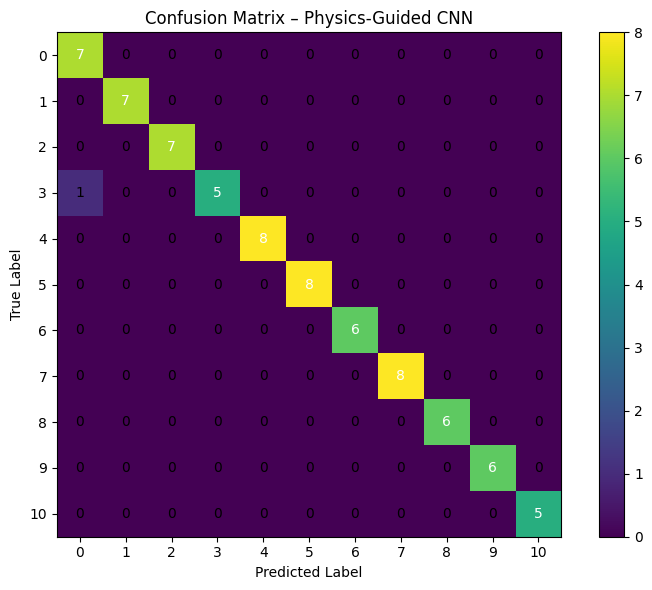

In [ ]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import numpy as np

# # Compute confusion matrix
# cm = confusion_matrix(labels, preds)

# # Plot
# plt.figure(figsize=(8, 6))
# plt.imshow(cm, interpolation="nearest")
# plt.title("Confusion Matrix – Physics-Guided CNN")
# plt.colorbar()

# tick_marks = np.arange(len(np.unique(labels)))
# plt.xticks(tick_marks, tick_marks)
# plt.yticks(tick_marks, tick_marks)

# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")

# # Annotate values
# thresh = cm.max() / 2
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         plt.text(
#             j, i, cm[i, j],
#             ha="center", va="center",
#             color="white" if cm[i, j] > thresh else "black"
#         )

# plt.tight_layout()
# plt.show()
